# [Load and preprocess images](https://www.tensorflow.org/tutorials/load_data/images)

This tutorial shows how to load and preprocess an image dataset in three ways:

- First, you will use high-level Keras preprocessing utilities (such as [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)) and layers (such as [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling)) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch [using tf.data](https://www.tensorflow.org/guide/data).
- Finally, you will download a dataset from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in [TensorFlow Datasets](https://www.tensorflow.org/datasets).

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2024-05-03 08:54:10.720242: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
# data_dir = pathlib.Path(archive).with_suffix('')
data_dir = pathlib.Path("/home/appuser/.keras/datasets/flower_photos")

In [6]:
os.listdir(data_dir)

['sunflowers', 'daisy', 'LICENSE.txt', 'tulips', 'dandelion', 'roses']

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
display(data_dir.glob('*/*.jpg'))
print(image_count)

<generator object Path.glob at 0x7ab55ff5ce10>

3670


PosixPath('/home/appuser/.keras/datasets/flower_photos/roses/11944957684_2cc806276e.jpg')

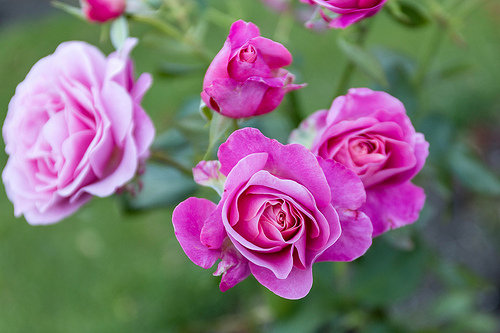

In [8]:
roses = list(data_dir.glob('roses/*'))
display(roses[0])
PIL.Image.open(str(roses[0]))

# Load data using a Keras utility: `tf.keras.utils.image_dataset_from_directory`

### Create a dataset

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2024-05-03 08:55:18.742564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 08:55:18.746148: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 08:55:18.746241: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


#### `class_names` attribute on datasets

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

2024-05-03 08:55:27.441766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


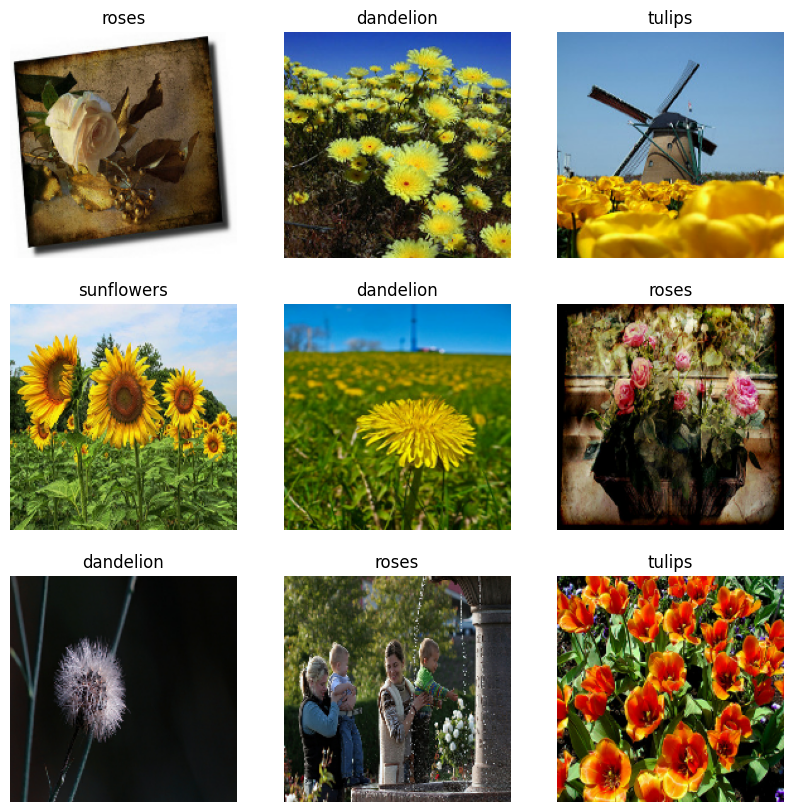

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


ou can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data
Here, you will standardize values to be in the `[0, 1]` range by using [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling):

In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer.  
* You can apply it to the dataset by calling [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map):
* Or, you can include the layer inside your model definition to simplify deployment. You will use the second approach here.

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


**Note:** If you would like to scale pixel values to `[-1,1]` you can instead write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`



**Note:** You previously resized images using the `image_size` argument of [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). If you want to include the resizing logic in your model as well, you can use the [`tf.keras.layers.Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing) layer.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.repeat(2).shuffle(buffer_size=100).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
data = next(iter(train_ds.take(1)))[0]
data.shape

2024-05-03 08:55:49.180578: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TensorShape([32, 180, 180, 3])

In [23]:
def get_min_max_of_img(img_np: np.array):
  img_np = img_np.reshape([-1])
  return(img_np.min(), img_np.max())

for image, label in train_ds.take(1):
  print(get_min_max_of_img(image.numpy()))

(0.0, 255.0)


2024-05-03 08:57:31.181087: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-03 08:57:31.185272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-05-03 09:12:14.338703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


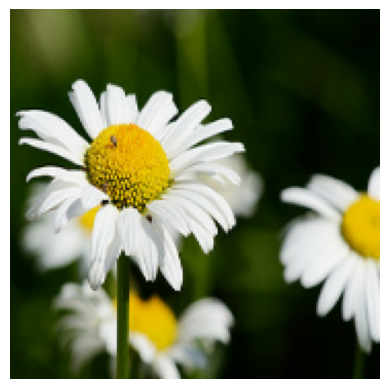

In [40]:
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis('off')

### Train the model

In [19]:
steps_per_epoch = len(train_ds)  # total train samples / batch size
steps_per_epoch

184

In [20]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=steps_per_epoch*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [25]:
def create_model():
    num_classes = 5
    
    model = tf.keras.Sequential([
      tf.keras.layers.Input((180, 180, 3)),
      tf.keras.layers.Rescaling(1./255),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(num_classes)
    ])
    
    model.compile(
      # optimizer='adam',
      optimizer=get_optimizer(), 
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,658,565 (6.33 MB)

 Trainable params: 1,658,565 (6.33 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
checkpoint_path = "training_1/flower_classification.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                   save_weights_only=True,
                                                   save_best_only=True,
                                                   verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  callbacks=[checkpoint_cb]
  # callbacks=[checkpoint_cb, early_stopping_cb]
)

## Test

2024-05-03 09:12:23.942861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


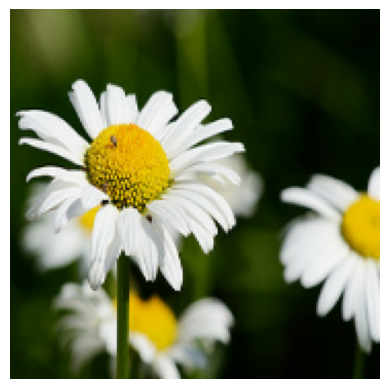

In [41]:
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
0.59375
[2 0 3 2 4 2 3 1 2 2 1 0 1 2 3 3 0 1 1 0 4 3 0 3 1 0 0 1 3 3 1 3]
[1 0 3 2 4 2 3 1 2 4 4 1 1 1 3 3 0 4 1 2 0 3 4 1 4 4 0 1 2 3 1 3]
sunflowers wrong... in fact daisy
sunflowers wrong... in fact tulips
daisy wrong... in fact tulips
dandelion wrong... in fact daisy
sunflowers wrong... in fact daisy
daisy wrong... in fact tulips
dandelion wrong... in fact sunflowers
tulips wrong... in fact dandelion
dandelion wrong... in fact tulips
roses wrong... in fact daisy
daisy wrong... in fact tulips
dandelion wrong... in fact tulips
roses wrong... in fact sunflowers


2024-05-03 09:18:19.486973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


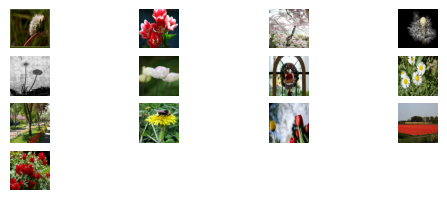

In [47]:
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    pred = np.argmax(predictions, axis=1)
    true = labels.numpy()
    mask = pred != true

    print((mask.size - mask.sum()) / mask.size)
    print(pred)
    print(true)

    wrong_pred = pred[mask]
    correct = true[mask]
    false_imgs = images[mask]
    pos = 0
    for w, c, i in zip(wrong_pred, correct, false_imgs):
        ax = plt.subplot(8, 4, pos + 1)
        plt.imshow(i.numpy().astype("uint8"))
        print(f'{class_names[labels[w]]} wrong... in fact {class_names[labels[c]]}')
        plt.axis("off")
        pos += 1